### Implementation of [SIRR Using Deep Encoder-Decoder Network](https://arxiv.org/abs/1802.00094)

[Review of the paper](https://github.com/topilskiyak/glare/blob/master/research/latex/research.pdf)

## TODone

~3 find_lr plot~

~2 More suggestions for dataset generation~  
~ add hellooks  
~ remove cv2-unreadable images  
~ split file list into train-val  
~ simple augmentations on CPU using albumentations  
~ dataloaders: num_workers > 0 (best=4 out of [1-5])  
~ Transmission/Refletion=indoor/outdoor + switch
~ model.compute_all

~1 Improve performance of dataset generation~  
~ Implemented dataset generation using [kornia](https://kornia.readthedocs.io/en/latest/) on GPU (-2s)  
~ ImageFolder: switched from default loader=PIL to loader=cv2.imread  (-0.2s)  
Currently: ~0.85s per batch=[64,3,128,128]  
(raw imagefolder->img2tensor->float->(gpu)resize is ~0.75s/b)  
NUM_DATALOADER_WORKERS=0 (CUDA forbids fork used as default for dataloader)  
TODO:  
~ time-profile further  
~ map image-folder into tmpfs (RAM) (or load all images into RAM)  
~ pregenerate the whole dataset, save it and during training only load  
~ use fixed gaussian kernel size instead of auto-determining it  
~ use [spawn](https://pytorch.org/docs/stable/notes/multiprocessing.html#multiprocessing-best-practices) for multiple workers in [dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)  
~ change [torchvision backend](https://pytorch.org/docs/stable/torchvision/index.html#torchvision.get_image_backend) to [accimage](https://github.com/pytorch/accimage)



## TODO

4 add test dataset  
6 vgg-loss  
7 find_lr (into cyclic\_lr?) @fastai, etc  
8 add get_examples to model

Ideas  
~ apply real-image-constraints (float->byte->float)  
~ negative sampling of bad restorations

Extra  
~ [truncate gaussian kernels](https://github.com/scipy/scipy/blob/v1.5.3/scipy/ndimage/filters.py#L212)

In [1]:
# https://kornia.readthedocs.io/en/latest/
!pip install kornia

#https://github.com/albumentations-team/albumentations
!pip uninstall -y albumentations
!pip install albumentations

     |████████████████████████████████| 225kB 7.8MB/s 
Uninstalling albumentations-0.1.12:
  Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 36.7MB 87kB/s 
     |████████████████████████████████| 952kB 52.6MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [2]:
# Imports
import itertools
import json
import os
from functools import partial
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

from torchsummary import summary

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

import albumentations as A
def transform_wrapper(transform):
    def wrapped(image):
        return transform(image=image)["image"]
    return wrapped

import kornia

In [3]:
# Global Variables
DEBUG = False

DATASET_PATHS = {
    'indoor':  '/content/indoor',
    'outdoor': '/content/outdoor',
}
VAL_PART = 0.2
DATASET_SPLIT_FILES_SEED = 236951592

IMG_SHAPE = np.array([128, 128])
IMG_SHAPE_EXTRA = 1.1

AUGMENTATIONS = transform_wrapper(A.Compose([
    A.Rotate(limit=90, p=0.5),
    A.RandomResizedCrop(*((IMG_SHAPE * IMG_SHAPE_EXTRA).astype(int)))
]))

NUM_DATALOADER_WORKERS = 4

GAUSSIAN_KERNEL_SHAPE = (7, 7)
REFLECTION_KERNEL_SHAPE = (3, 3)

DEVICE = 'cuda'

MAX_EPOCHS = 100
BATCH_SIZE = 24 #32
LEARNING_RATE = 1e-4   # find_lr=[3e-5,7e-4]   explode@1e-3

## Helpers

In [4]:
def imshow(img):
    plt.imshow(img)
    plt.show()

def imshow_chw(img):
    imshow(np.transpose(img, axes=(1, 2, 0)))

def imshow_floattensor(t):
    t = torch.clip(t, 0, 1)
    img = (t * 255).byte().cpu().numpy()
    imshow_chw(img)

## Dataset

In [5]:
# google_drive.py

import distutils.dir_util
import distutils.file_util
from pathlib import Path

from google.colab import drive

def copy(src, dst):
    if src.is_dir():
        distutils.dir_util.copy_tree(str(src), str(dst))
    elif src.is_file():
        distutils.file_util.copy_file(str(src), str(dst))

def copy_from_drive(local_path, drive_path, mount_path='/mnt/gdrive'):
    drive.mount(mount_path)
    src = Path(mount_path) / 'My Drive' / drive_path
    dst = Path(local_path)
    copy(src, dst)

def copy_to_drive(local_path, drive_path, mount_path='/mnt/gdrive'):
    drive.mount(mount_path)
    src = Path(local_path)
    dst = Path(mount_path) / 'My Drive' / drive_path
    copy(src, dst)

In [6]:
if not Path(DATASET_PATHS['outdoor']).exists():
    copy_from_drive('.', 'data/glare')
    !unzip -q hellooks.zip
    !mv astigma_images {DATASET_PATHS['outdoor']}
if not Path(DATASET_PATHS['indoor']).exists():
    !wget http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar -O indoorCVPR_09.tar
    !tar -C . -xf indoorCVPR_09.tar
    !mv Images {DATASET_PATHS['indoor']}
!ls /content

Mounted at /mnt/gdrive
--2020-12-14 13:35:29--  http://groups.csail.mit.edu/vision/LabelMe/NewImages/indoorCVPR_09.tar
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2592010240 (2.4G) [application/x-tar]
Saving to: ‘indoorCVPR_09.tar’

indoorCVPR_09.tar   100%[===================>]   2.41G  7.78MB/s    in 5m 40s  

2020-12-14 13:41:09 (7.28 MB/s) - ‘indoorCVPR_09.tar’ saved [2592010240/2592010240]

hellooks.zip  indoor  indoorCVPR_09.tar  outdoor  sample_data


In [7]:
def is_loadable(path):
    try:
        img_bgr = cv2.imread(path)
        return img_bgr is not None
    except:
        return False

def get_loadable_files(path):
    files = []
    for p in tqdm(list(path.glob('**/*'))):
        p = str(p.absolute())
        if is_loadable(p):
            files.append(p)
    return files

def get_files(paths, use_cache=True):
    dataset_files = {}
    for name, path in paths.items():
        path = Path(path)
        cache = path.with_suffix('.files_cache.json')

        if use_cache and cache.exists():
            print(f'Loading files cache for {name}')
            dataset_files[name] = {'all': json.load(cache.open('r'))}
            continue

        print(f'Getting loadable files for {name}')
        loadable_files = get_loadable_files(path)
        if use_cache:
            json.dump(loadable_files, cache.open('w'))
        dataset_files[name] = {'all': loadable_files}

    return dataset_files


dataset_files = get_files(DATASET_PATHS)


if DEBUG:
    for name, files in dataset_files.items():
        print(f'len({name})={len(files["all"])}')

Getting loadable files for indoor



Getting loadable files for outdoor


In [8]:
def split_files(dataset_files, val_part, seed):
    rng = np.random.default_rng(seed=seed)
    for name, files in dataset_files.items():
        all = np.array(files['all'])

        ids = np.arange(len(all))
        rng.shuffle(ids)

        val_len = int(val_part * len(all))
        train_ids = ids[val_len:]
        val_ids = ids[:val_len]

        files['all'] = all
        files['val'] = all[val_ids]
        files['train'] = all[train_ids]


split_files(dataset_files, val_part=VAL_PART, seed=DATASET_SPLIT_FILES_SEED)


if DEBUG:
    for name, parts in dataset_files.items():
        print(name)
        for part, files in parts.items():
            print(f'  len({part})={len(files)}')
            print(f'    example="{files[len(files) // 2]}"')

In [9]:
def cv2loader(path):
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

class TransformedImages(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, item):
        path = self.files[item]
        img = cv2loader(path)
        if self.transform:
            img = self.transform(img)
        return np.transpose(img, axes=(-1, 0, 1))

def get_datasets(files, parts_transforms):
    datasets = {}
    for name, files in files.items():
        datasets_for_name = {}
        for part, transform in parts_transforms.items():
            datasets_for_name[part] = \
                TransformedImages(files=files[part], transform=transform)
        datasets[name] = datasets_for_name
    return datasets


parts_transforms = {
    'train': AUGMENTATIONS,
    'val': AUGMENTATIONS,
}

datasets = get_datasets(dataset_files, parts_transforms)


if DEBUG:
    for name, parts in datasets.items():
        print(f'##### {name} #####')
        for part, dataset in parts.items():
            print(f'  {part}')
            print(f'    len={len(dataset)}')

            ids = np.arange(len(dataset))
            np.random.shuffle(ids)

            print(f'    image stats')
            image = dataset[ids[len(ids) // 2]]
            print(f'      type={type(image)}, dtype={image.dtype}')
            print(f'      shape={image.shape}')
            print(f'      max={image.max():.2f}'
                  f', mean={image.mean():.2f}'
                  f', min={image.min():.2f}')
            imshow_chw(image)

            print(f'    testing loading')
            for i in tqdm(range(min(500, len(dataset)))):
                _ = dataset[ids[i]]

In [10]:
def get_dataloaders(datasets):
    dataloaders = {}
    for name, parts in datasets.items():
        dataloaders_for_name = {}
        for part, dataset in parts.items():
            dataloaders_for_name[part] = \
                DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True,
                          num_workers=NUM_DATALOADER_WORKERS)
        dataloaders[name] = dataloaders_for_name
    return dataloaders


dataloaders = get_dataloaders(datasets)


if DEBUG:
    for name, parts in dataloaders.items():
        print(f'##### {name} #####')
        for part, dataloader in parts.items():
            print(f'  {part}')
            print(f'    len={len(dataloader)}')

            dataset = datasets[name][part]
            assert len(dataloader) == len(dataset) // BATCH_SIZE

            image = dataset[0]
            for batch in tqdm(dataloader):
                assert batch.size()[0] == BATCH_SIZE
                assert batch.size()[1:] == image.shape

In [11]:
class FusedDataloader:
    def __init__(self, main_name, names, dataloaders, length):
        self.main_name = main_name
        self.names = names
        self.dataloaders = dataloaders
        self.length = length
        self.iter = None

    def __len__(self):
        return self.length
  
    def __iter__(self):
        self.iter = iter(zip(*self.dataloaders))
        return self
    
    def __next__(self):
        b = next(self.iter)
        return dict(zip(self.names, b))

def repeat(dataloader):
    while True:
        for b in dataloader:
            yield b
  

def get_fused_dataloaders(dataloaders, main_dataloader):
    def get_fused(part):
        names = []
        dataloaders_for_part = []
        length = len(dataloaders[main_dataloader][part])
        for name, parts in dataloaders.items():
            dataloader = parts[part]
            if name != main_dataloader:
                dataloader = repeat(dataloader)
            names.append(name)
            dataloaders_for_part.append(dataloader)
        return FusedDataloader(main_dataloader, names, dataloaders_for_part, length)
    parts = datasets[main_dataloader].keys()
    return {part: get_fused(part) for part in parts}

def get_largest_dataloader_name(dataloaders):
    flat_dataloaders = []
    for name, parts in dataloaders.items():
        for part, dataloader in parts.items():
            flat_dataloaders.append((name, part, dataloader))
    flat_dataloaders = sorted(flat_dataloaders, key=lambda x: len(x[-1]))
    largest_dataloader = flat_dataloaders[-1][0]
    return largest_dataloader

main_dataloader = get_largest_dataloader_name(dataloaders)
fused_dataloaders = get_fused_dataloaders(dataloaders, main_dataloader)


if DEBUG:
  for part, dataloader in fused_dataloaders.items():
      print(f'##### {part} #####')
      print(f'  len={len(dataloader)}')
      assert len(dataloader) == len(dataloaders[main_dataloader][part])

      batch = None
      for batch in tqdm(dataloader):
          pass

      for name, img in batch.items():
          target = None
          for target in dataloaders[name][part]:
              break
          assert img.size() == target.size()

In [12]:
class SIRRSettings:
    def __init__(self, alpha=(0.75, 0.8), sigma=(1, 5),
                img_shape=IMG_SHAPE,
                gaussian_kernel_shape=GAUSSIAN_KERNEL_SHAPE,
                reflection_kernel_shape=REFLECTION_KERNEL_SHAPE):
        self.balpha = alpha[0]
        self.dalpha = alpha[1] - alpha[0]
        self.bsigma = sigma[0]
        self.dsigma = sigma[1] - sigma[0]
        self.img_shape = tuple(img_shape)
        self.gaussian_kernel_shape = gaussian_kernel_shape
        self.reflection_kernel_shape = reflection_kernel_shape

class ModuleWithSIRRComputeAll(nn.Module):
    def set_device(self, device):
        self.device = device

    def set_settings(self, sirr_settings):
        self.sirr_settings = sirr_settings
        self.center_crop = kornia.augmentation.CenterCrop(
            sirr_settings.img_shape, p=1.0)

    def set_criterion(self, criterion):
        self.criterion = criterion
    
    def preprocess(self, image):
        return image.to(self.device).float() / 255

    def get_alpha(self, size):
        alpha = torch.rand(size, device=self.device)
        alpha *= self.sirr_settings.dalpha
        alpha += self.sirr_settings.balpha
        return alpha
  
    def get_gaussian_kernel(self, size):
        sigma = np.random.rand(size)
        sigma *= self.sirr_settings.dsigma
        sigma += self.sirr_settings.bsigma
        shape = self.sirr_settings.gaussian_kernel_shape
        kernels = [
            kornia.filters.get_gaussian_kernel2d(shape, (s, s)) for s in sigma]
        return torch.stack(kernels, dim=0).to(self.device)

    def get_double_reflection_kernel(self, alpha):
        shape = self.sirr_settings.reflection_kernel_shape
        sqrt_alpha = torch.sqrt(alpha)

        size = shape[0] * shape[1]
        n_alpha = alpha.size()[0]

        reflections = np.random.randint(0, size, (n_alpha, 2))
        reflections += np.arange(n_alpha)[:, np.newaxis] * size

        kernel = torch.zeros(
            size=(n_alpha * size,), dtype=alpha.dtype, device=self.device)
        kernel[reflections[:, 0]] += (1 - sqrt_alpha) / (1 - alpha)
        kernel[reflections[:, 1]] += (sqrt_alpha - alpha) / (1 - alpha)
        return kernel.reshape((n_alpha, *shape))
  
    def get_reflection(self, reflection, alpha):
        blur_kernel = self.get_gaussian_kernel(reflection.size()[0])
        double_reflection_kernel = self.get_double_reflection_kernel(alpha)

        blurred_doubled_kernel = kornia.filter2D(
            blur_kernel.unsqueeze(dim=1), double_reflection_kernel,
            border_type='constant')
        reflection_blurred_doubled = kornia.filter2D(
            reflection, blurred_doubled_kernel.squeeze(dim=1),
            border_type='reflect')

        reflection = self.center_crop(reflection_blurred_doubled)
        return reflection

    def get_batch(self, transmission, reflection):
        alpha = self.get_alpha(transmission.size()[0])
        alpha_ = alpha.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

        transmission = self.center_crop(transmission)
        alpha_transmission = alpha_ * transmission

        reflection = self.get_reflection(reflection, alpha)

        image = alpha_transmission + (1 - alpha_) * reflection

        return {
            'image': image, 
            'alpha_transmission': alpha_transmission,
            'alpha': alpha,
            'transmission': transmission,
            'reflection': reflection,
        }

    def compute_loss_(self, transmission, reflection):
        batch = self.get_batch(transmission, reflection)
        input = batch['image']
        target = batch['alpha_transmission']

        pred = self.forward(input)
        loss = self.criterion(pred, target)
        return loss

    def compute_loss(self, batch):
        loss = 0
        combinations = 0
        for subset in itertools.combinations(list(batch.keys()), 2):
            first, second = batch[subset[0]], batch[subset[1]]
            loss += self.compute_loss_(first, second)
            loss += self.compute_loss_(second, first)
            combinations += 2
        loss /= max(combinations, 1)
        return loss

    def compute_all(self, batch):
        batch = {name:self.preprocess(image) for name, image in batch.items()}
        details = {}
        details['loss'] = self.compute_loss(batch)
        return details


if DEBUG:
    module = ModuleWithSIRRComputeAll()
    module.set_device(DEVICE)
    module.set_settings(SIRRSettings())

    print('Testing')

    print('  get_alpha')
    size = 100
    alpha = module.get_alpha(size).cpu().numpy()
    assert alpha.shape == (size,)
    assert np.all(alpha >= module.sirr_settings.balpha)
    assert np.all(alpha <= module.sirr_settings.balpha + module.sirr_settings.dalpha)

    print('  get_gaussian_kernel')
    size = 100
    kernel = module.get_gaussian_kernel(100).cpu().numpy()
    assert kernel.shape == (size, *module.sirr_settings.gaussian_kernel_shape)
    assert np.all(kernel >= 0) and np.all(kernel <= 1)
    assert np.allclose(kernel.sum(axis=(-1, -2)), 1)

    print('  get_double_reflection_kernel')
    size = 100
    alpha = module.get_alpha(size)
    kernel = module.get_double_reflection_kernel(alpha).cpu().numpy()
    assert kernel.shape == (size, *module.sirr_settings.reflection_kernel_shape)
    assert np.allclose(kernel.sum(axis=(-1, -2)), 1)
    assert np.all(kernel >= 0)
    assert np.all((kernel > 0).sum(axis=(-1, -2)) <= 2)

    batch = None
    dataloader = list(fused_dataloaders.values())[0]
    for batch in dataloader:
        break

    print('  preprocess')
    reflection = module.preprocess(batch['indoor'])
    transmission = module.preprocess(batch['outdoor'])
    reflection_ = reflection.cpu().numpy()
    transmission_ = transmission.cpu().numpy()
    for image_ in [reflection_, transmission_]:
        assert np.all(image_ >= 0) and np.all(image_ <= 1)

    print('  get_reflection')
    alpha = module.get_alpha(reflection.size()[0])
    reflection_ = module.get_reflection(reflection, alpha)
    print('    input')
    imshow_floattensor(reflection[0])
    print('    reflection')
    imshow_floattensor(reflection_[0])
    print()

    print('  get_batch')
    batch = module.get_batch(transmission, reflection)
    print('    image')
    imshow_floattensor(batch['image'][0])
    print('    transmission')
    imshow_floattensor(batch['transmission'][0])
    print('    reflection')
    imshow_floattensor(batch['reflection'][0])


## Architecture

In [13]:
def wrap_(layer, in_, out, kernel_size, activation=None, padding=0, padding_mode='zeros'):
    layers = []

    layer_ = layer(in_, out, kernel_size=kernel_size, 
                   padding=padding, padding_mode=padding_mode)
    layers.append(layer_)
    
    if activation is not None:
        activation_ = activation()
        layers.append(activation_)

    return nn.Sequential(*layers)


def wrap_reflectpad(layer, in_, out, kernel_size, activation=None):
    return wrap_(nn.Conv2d, in_, out, kernel_size, activation,
                 padding = kernel_size // 2, padding_mode='reflect')


wrap = wrap_reflectpad

In [14]:
class FeatureExtractionCNN(nn.Module):
    def __init__(self, in_, filters):
        super(FeatureExtractionCNN, self).__init__()
        self.cnn = nn.Sequential(
            wrap(nn.Conv2d, in_,     filters, kernel_size=9, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=9, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=None),
            # skip-connection add/sub works with features before ReLU
        )
    
    def forward(self, x):
        return self.cnn(x)


class RRUNetDownBlock(nn.Module):
    def __init__(self, filters):
        super(RRUNetDownBlock, self).__init__()
        self.cnn = nn.Sequential(
            nn.ReLU(),
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.Conv2d, filters, filters, kernel_size=5, activation=None),
        )
    def forward(self, x):
        return self.cnn(x)

class RRUNetUpBlock(nn.Module):
    def __init__(self, filters):
        super(RRUNetUpBlock, self).__init__()
        self.cnn = nn.Sequential(
            nn.ReLU(),
            wrap(nn.ConvTranspose2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.ConvTranspose2d, filters, filters, kernel_size=5, activation=None),
        )
    def forward(self, x):
        return self.cnn(x)

class ReflectionRemovalUNet(nn.Module):
    def __init__(self, filters, depth):
        super(ReflectionRemovalUNet, self).__init__()
        self.down = nn.ModuleList([RRUNetDownBlock(filters) for _ in range(depth)])
        self.up = nn.ModuleList([RRUNetUpBlock(filters) for _ in range(depth)])
        assert len(self.down) == len(self.up)
    
    def forward(self, x):
      reflection = x

      down_features = []
      for down in self.down[:-1]:
          reflection = down(reflection)
          down_features.append(reflection)

      reflection = self.down[-1](reflection)
      reflection = self.up[0](reflection)

      for up, skip_features in zip(self.up[1:], reversed(down_features)):
          #reflection += skip_features
          reflection = up(reflection)

      return reflection #F.relu(x - reflection)


class TransmissionRestorationCNN(nn.Module):
    def __init__(self, filters, out):
        super(TransmissionRestorationCNN, self).__init__()
        self.cnn = nn.Sequential(
            wrap(nn.ConvTranspose2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.ConvTranspose2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.ConvTranspose2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.ConvTranspose2d, filters, filters, kernel_size=5, activation=nn.ReLU),
            wrap(nn.ConvTranspose2d, filters, filters, kernel_size=9, activation=nn.ReLU),
            wrap(nn.ConvTranspose2d, filters, out,     kernel_size=9, activation=nn.ReLU),
            # TODO: skip last relu, since clip01 afterwards anyway?
        )
    
    def forward(self, x):
        return self.cnn(x)


class SIRRNet(ModuleWithSIRRComputeAll):
    def __init__(self, in_, filters, depth):
        super(SIRRNet, self).__init__()
        self.feature_extraction = FeatureExtractionCNN(in_, filters)
        self.reflection_removal = ReflectionRemovalUNet(filters, depth)
        self.transmission_restoration = TransmissionRestorationCNN(filters, in_)
    
    def forward(self, x):
        features = self.feature_extraction(x)
        features_reflection_removed = self.reflection_removal(features)
        restored = self.transmission_restoration(features_reflection_removed)
        return restored

model = SIRRNet(in_=3, filters=64, depth=3).to(DEVICE)

if DEBUG:
    summary(model, (3, *IMG_SHAPE))

## Loss Function

In [15]:
def setup_model(model):
    model.set_device(DEVICE)
    model.set_settings(SIRRSettings())

    criterion = nn.MSELoss()
    model.set_criterion(criterion)

setup_model(model)

## Optimizer

In [16]:
def find_lr(model, dataloader, optimizer, lr_logmin=-7, lr_logmax=1):
    lr = np.logspace(lr_logmin, lr_logmax, len(dataloader))
    losses = []
    for lr_, batch in zip(lr, tqdm(dataloader)):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_
        details = model.compute_all(batch)
        optimizer.zero_grad()
        loss = details['loss']
        loss.backward()
        optimizer.step()
        losses.append(details['loss'].item())
    return lr, losses

def plot_lr(lr, losses):
    losses = np.array(losses)
    mask = ~np.isnan(losses)

    ylim_min = min(losses) * 0.5
    ylim_max = np.quantile(losses[mask], q=0.8) * 1.5

    plt.plot(lr[mask], losses[mask])
    plt.xscale('log')
    plt.ylim([ylim_min, ylim_max])
    plt.ylabel('loss')
    plt.xlabel('lr')
    plt.show()


if False:
    model_ = SIRRNet(in_=3, filters=64, depth=3).to(DEVICE)
    setup_model(model_)
    optimizer = torch.optim.Adam(model_.parameters(), lr=LEARNING_RATE)

    lr, losses = find_lr(model_, fused_dataloaders['train'], optimizer,
                        lr_logmin=-6, lr_logmax=-1)
    plot_lr(lr, losses)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [18]:
def run_epoch(model, dataloader, optimizer=None, description=""):
    losses = []
    pbar = tqdm(dataloader)
    for batch in pbar:
        details = model.compute_all(batch)
        if optimizer is not None:
            optimizer.zero_grad()
            loss = details['loss']
            loss.backward()
            optimizer.step()

        losses.append(details['loss'].item())
        mean_loss = np.mean(losses[-10:] if optimizer is not None else losses)
        pbar.set_description(
            f'{description}: '
            f'loss={mean_loss:.5f}, '
            f'psnr={- 10 * np.log10(mean_loss):.1f}')
    
    return losses

def train_epoch(model, dataloader, optimizer):
    model.train()
    return run_epoch(model, dataloader, optimizer, description='TR')

def evaluate(model, dataloader):
    with torch.no_grad():
        model.eval()
        return run_epoch(model, dataloader, optimizer=None, description='TV')

def train(model, fused_dataloaders, optimizer, max_epochs):
    running_statistics = {
        "train": {"loss": []},
        "val":  {"loss": []}
    }

    try:
        for epoch in tqdm(range(max_epochs)):
            print(f"epoch={epoch:03d}")
            loss = train_epoch(model, fused_dataloaders['train'], optimizer)
            val_loss = evaluate(model, fused_dataloaders['val'])

            running_statistics["train"]["loss"].append(loss)
            running_statistics["val"]["loss"].append(val_loss)

            #TODO: early stopping using val_loss
    except KeyboardInterrupt:
        print("KeyboardInterrupt")

    print("Finished training.")
    return running_statistics


In [ ]:
# warmup training?
# batchnorm? layernorm?
# vggloss?

# split into local,colab,kaggle (with auto-определение)

# black-corners because padding=0, so -16pix in middle restoration - take 128x128?

In [ ]:
_ = train(model, fused_dataloaders, optimizer, MAX_EPOCHS)

epoch=000



epoch=001



epoch=002



epoch=003



epoch=004



epoch=005



epoch=006



epoch=007



epoch=008



epoch=009



epoch=010



epoch=011



epoch=012



epoch=013



epoch=014



epoch=015



epoch=016


KeyboardInterrupt
Finished training.


In [ ]:
torch.save(model.state_dict(), '128_fullconv_relfpad.state_dict')

## Evaluation

In [20]:
model.load_state_dict(torch.load('128_fullconv_relfpad_psnr25.state_dict'))

fused_dataloaders = get_fused_dataloaders(dataloaders, main_dataloader)
_ = evaluate(model, fused_dataloaders['val'])

In [ ]:
def imshow_samples(example, dataloader, n_samples=2, figsize=(16, 8)):
    parts = ['reflection', 'image', 'pred', 'transmission']
    samples = []
    with torch.no_grad():
        model.eval()
        for i, batch in zip(tqdm(range(n_samples)), dataloader):
            batch = {name:model.preprocess(image) for name, image in batch.items()}
            batch_l = list(batch.values())
            transmission, reflection = batch_l[0], batch_l[1]
            batch = model.get_batch(transmission, reflection)
            batch['pred'] = model.forward(batch['image'])
            j = np.random.randint(BATCH_SIZE)
            samples.append({part: batch[part][j].detach() for part in parts})
    
    _, axes = plt.subplots(n_samples, len(parts), figsize=figsize, squeeze=False)
    for part, ax in zip(parts, axes[0]):
        ax.set_title(part)
    for sample, axes_row in zip(samples, axes):
        for part, ax in zip(parts, axes_row):
            ax.set_axis_off()
            t = sample[part]
            img_chw = (torch.clip(t, 0, 1) * 255).byte().cpu().numpy()
            img = np.transpose(img_chw, axes=(1, 2, 0))
            ax.imshow(img)
    plt.show()


In [ ]:
# e=25 lr=1e-4 psnr=25   128x128
fused_dataloaders = get_fused_dataloaders(dataloaders, main_dataloader)
imshow_samples(model, fused_dataloaders['train'], n_samples=5, figsize=(16, 16))

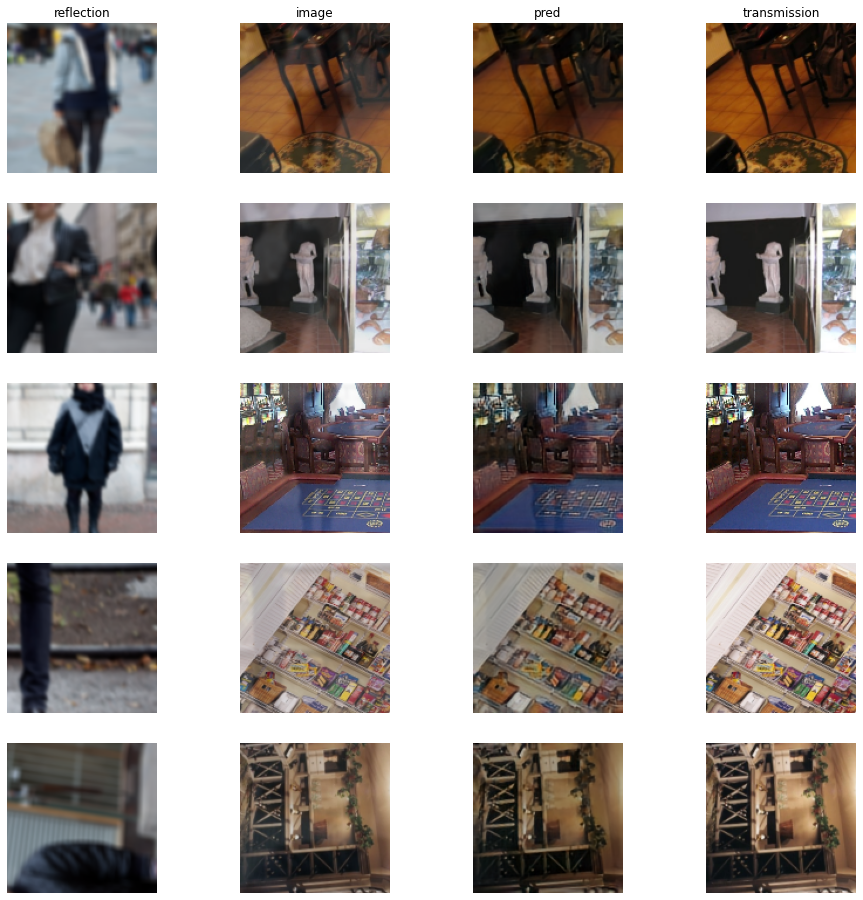

In [ ]:
# e=25 lr=1e-4 psnr=25   128x128
fused_dataloaders = get_fused_dataloaders(dataloaders, main_dataloader)
imshow_samples(model, fused_dataloaders['train'], n_samples=5, figsize=(16, 16))